# Changes
- Max features < 1000

In [1]:
!ls -l ../input/

total 92288
-rw-r--r-- 1 root root  1230867 Dec 17  2018 sample_submission.csv
-rw-r--r-- 1 root root  1800682 Dec 17  2018 site_dic.pkl
-rw-r--r-- 1 root root 19450729 Dec 17  2018 test_sessions.csv
-rw-r--r-- 1 root root 11483103 Dec 17  2018 train.zip
-rw-r--r-- 1 root root 60526801 Dec 17  2018 train_sessions.csv


In [2]:
!head ../input/train_sessions.csv

session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
1,718,2014-02-20 10:02:45,,,,,,,,,,,,,,,,,,,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,3846,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,39,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,782,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 1

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve

We will be solving the intruder detection problem analyzing his behavior on the Internet. It is a complicated and interesting problem combining the data analysis and behavioral psychology.

For example: Yandex solves the mailbox intruder detection problem based on the user's behavior patterns. In a nutshell, intruder's behaviour pattern might differ from the owner's one: 
- the breaker might not delete emails right after they are read, as the mailbox owner might do
- the intruder might mark emails and even move the cursor differently
- etc.

So the intruder could be detected and thrown out from the mailbox proposing the owner to be authentificated via SMS-code.
This pilot project is described in the Habrahabr article.

Similar things are being developed in Google Analytics and described in scientific researches. You can find more on this topic by searching "Traversal Pattern Mining" and "Sequential Pattern Mining".

In this competition we are going to solve a similar problem: our algorithm is supposed to analyze the sequence of websites consequently visited by a particular person and to predict whether this person is Alice or an intruder (someone else). As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). We will reveal who Alice is at the end of the course.

###  Data Downloading and Transformation
First, read the training and test sets. 

In [4]:
# Read the training and test data sets
train_df = pd.read_csv('../input/train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('../input/test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

In [5]:
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(2), object(9)
memory usage: 42.6+ MB
None


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(9)
memory usage: 13.3+ MB
None


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [7]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, possesses value of 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way they are not longer than half an hour or/and contain more than ten websites. I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:

In [8]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
site_feature_names = [x for x in train_df.columns if 'site' in x]
for df in (train_df, test_df):
    df[site_feature_names] = df[site_feature_names].fillna(-1).astype('int')
train_df[site_feature_names].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


In [9]:
%%time
# Add siteMN... features
site_feature_names = [x for x in train_df.columns if 'site' in x]
for df in (train_df, test_df):
    for l in range(2,len(site_feature_names)):
        for i in range(len(site_feature_names)-l+1):
            print('Progress: %d/%d, %d/%d\r' % (l,len(site_feature_names)-1,i,len(site_feature_names)-l), end='')
            df['site' + str(i) + str(l)] = df[site_feature_names[i:i+l]].astype('str').apply(lambda x: '_'.join(x), axis=1)

feature_names = [x for x in train_df.columns if 'site' in x]
print(feature_names[:1000])
print(feature_names[-1000:])
train_df[feature_names].head()

['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'site02', 'site12', 'site22', 'site32', 'site42', 'site52', 'site62', 'site72', 'site82', 'site03', 'site13', 'site23', 'site33', 'site43', 'site53', 'site63', 'site73', 'site04', 'site14', 'site24', 'site34', 'site44', 'site54', 'site64', 'site05', 'site15', 'site25', 'site35', 'site45', 'site55', 'site06', 'site16', 'site26', 'site36', 'site46', 'site07', 'site17', 'site27', 'site37', 'site08', 'site18', 'site28', 'site09', 'site19']
['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'site02', 'site12', 'site22', 'site32', 'site42', 'site52', 'site62', 'site72', 'site82', 'site03', 'site13', 'site23', 'site33', 'site43', 'site53', 'site63', 'site73', 'site04', 'site14', 'site24', 'site34', 'site44', 'site54', 'site64', 'site05', 'site15', 'site25', 'site35', 'site45', 'site55', 'site06', 'site16', 'site26', 'site36', 'site46', 'site07', 'site17', 'site2

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,site46,site07,site17,site27,site37,site08,site18,site28,site09,site19
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1_-1_-1_-1_-1_-1,718_-1_-1_-1_-1_-1_-1,-1_-1_-1_-1_-1_-1_-1,-1_-1_-1_-1_-1_-1_-1,-1_-1_-1_-1_-1_-1_-1,718_-1_-1_-1_-1_-1_-1_-1,-1_-1_-1_-1_-1_-1_-1_-1,-1_-1_-1_-1_-1_-1_-1_-1,718_-1_-1_-1_-1_-1_-1_-1_-1,-1_-1_-1_-1_-1_-1_-1_-1_-1
2,890,941,3847,941,942,3846,3847,3846,1516,1518,...,942_3846_3847_3846_1516_1518,890_941_3847_941_942_3846_3847,941_3847_941_942_3846_3847_3846,3847_941_942_3846_3847_3846_1516,941_942_3846_3847_3846_1516_1518,890_941_3847_941_942_3846_3847_3846,941_3847_941_942_3846_3847_3846_1516,3847_941_942_3846_3847_3846_1516_1518,890_941_3847_941_942_3846_3847_3846_1516,941_3847_941_942_3846_3847_3846_1516_1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,...,37_39_14768_14768_14768_14768,14769_39_14768_14769_37_39_14768,39_14768_14769_37_39_14768_14768,14768_14769_37_39_14768_14768_14768,14769_37_39_14768_14768_14768_14768,14769_39_14768_14769_37_39_14768_14768,39_14768_14769_37_39_14768_14768_14768,14768_14769_37_39_14768_14768_14768_14768,14769_39_14768_14769_37_39_14768_14768_14768,39_14768_14769_37_39_14768_14768_14768_14768
4,782,782,782,782,782,782,782,782,782,782,...,782_782_782_782_782_782,782_782_782_782_782_782_782,782_782_782_782_782_782_782,782_782_782_782_782_782_782,782_782_782_782_782_782_782,782_782_782_782_782_782_782_782,782_782_782_782_782_782_782_782,782_782_782_782_782_782_782_782,782_782_782_782_782_782_782_782_782,782_782_782_782_782_782_782_782_782
5,22,177,175,178,177,178,175,177,177,178,...,177_178_175_177_177_178,22_177_175_178_177_178_175,177_175_178_177_178_175_177,175_178_177_178_175_177_177,178_177_178_175_177_177_178,22_177_175_178_177_178_175_177,177_175_178_177_178_175_177_177,175_178_177_178_175_177_177_178,22_177_175_178_177_178_175_177_177,177_175_178_177_178_175_177_177_178


In [10]:
# Fix timeN columns
time_feature_names = [x for x in train_df.columns if 'time' in x]
for df in (train_df, test_df):
    df[time_feature_names] = df[time_feature_names].fillna(0).astype('datetime64')
train_df[time_feature_names].head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
1,2014-02-20 10:02:45,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00
2,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16
3,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24
4,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42
5,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11


In [11]:
# Add dur, durN columns
for df in (train_df, test_df):
    df.drop([x for x in df.columns if 'dur' in x], axis=1, inplace=True)

for df in (train_df, test_df):
    df['timex'] = pd.to_datetime(0)
time_feature_names = [x for x in train_df.columns if 'time' in x]
for df in (train_df, test_df):
    for i,k in [(x,x+1) for x in range(len(time_feature_names)-1)]:
        df['dur' + str(i)] = (df[time_feature_names[k]] - df[time_feature_names[i]]).astype('timedelta64[s]').astype('int')
        df.loc[df[time_feature_names[k]].astype('int') == 0, 'dur' + str(i)] = 0
dur_feature_names = [x for x in df.columns if 'dur' in x]
for df in (train_df, test_df):
    impute_dur = df[dur_feature_names].median().median()
    df['dur'] = df[dur_feature_names].sum(axis=1)
    for i,k in [(x,x+1) for x in range(len(time_feature_names)-1)]:
        df.loc[df[time_feature_names[k]].astype('int') == 0, 'dur' + str(i)] = impute_dur
for df in (train_df, test_df):
    df.drop('timex', axis=1, inplace=True)

feature_names = [x for x in train_df.columns if 'dur' in x]
print(train_df[feature_names].info())
train_df[feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 11 columns):
dur0    253561 non-null float64
dur1    253561 non-null float64
dur2    253561 non-null float64
dur3    253561 non-null float64
dur4    253561 non-null float64
dur5    253561 non-null float64
dur6    253561 non-null float64
dur7    253561 non-null float64
dur8    253561 non-null float64
dur9    253561 non-null float64
dur     253561 non-null int64
dtypes: float64(10), int64(1)
memory usage: 23.2 MB
None


,dur0,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9,dur
session_id,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,1.0,26
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,7
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,1.0,270
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,1.0,246


In [12]:
# Add dayN, hourN, minN, monN, domN, weekN columns
time_feature_names = [x for x in train_df.columns if 'time' in x]
for df in (train_df, test_df):
    for i in range(len(time_feature_names)):
        df['cat_day' + str(i)] = df[time_feature_names[i]].dt.dayofweek
        df['cat_hour' + str(i)] = df[time_feature_names[i]].dt.hour
        df['cat_min' + str(i)] = df[time_feature_names[i]].dt.minute
        df['cat_mon' + str(i)] = df[time_feature_names[i]].dt.month
        df['cat_dom' + str(i)] = df[time_feature_names[i]].dt.day
        df['cat_week' + str(i)] = df[time_feature_names[i]].dt.week
        df['cat_day_hour' + str(i)] = df[time_feature_names[i]].dt.dayofweek.astype('str') + '_' + df[time_feature_names[i]].dt.hour.astype('str')
        cat_feature_names = [x for x in df.columns if 'cat' in x and str(i) in x]
        df.loc[df[time_feature_names[i]].astype('int') == 0, cat_feature_names] = -1
        df[cat_feature_names] = df[cat_feature_names].astype('str') # for OHE

cat_feature_names = [x for x in train_df.columns if 'cat' in x]
print(train_df[cat_feature_names].info())
train_df[cat_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 70 columns):
cat_day0         253561 non-null object
cat_hour0        253561 non-null object
cat_min0         253561 non-null object
cat_mon0         253561 non-null object
cat_dom0         253561 non-null object
cat_week0        253561 non-null object
cat_day_hour0    253561 non-null object
cat_day1         253561 non-null object
cat_hour1        253561 non-null object
cat_min1         253561 non-null object
cat_mon1         253561 non-null object
cat_dom1         253561 non-null object
cat_week1        253561 non-null object
cat_day_hour1    253561 non-null object
cat_day2         253561 non-null object
cat_hour2        253561 non-null object
cat_min2         253561 non-null object
cat_mon2         253561 non-null object
cat_dom2         253561 non-null object
cat_week2        253561 non-null object
cat_day_hour2    253561 non-null object
cat_day3         253561 non-null object
cat_hour3

,cat_day0,cat_hour0,cat_min0,cat_mon0,cat_dom0,cat_week0,cat_day_hour0,cat_day1,cat_hour1,cat_min1,...,cat_dom8,cat_week8,cat_day_hour8,cat_day9,cat_hour9,cat_min9,cat_mon9,cat_dom9,cat_week9,cat_day_hour9
session_id,,,,,,,,,,,,,,,,,,,,,
1,3,10,2,2,20,8,3_10,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,5,11,19,2,22,8,5_11,5,11,19,...,22,8,5_11,5,11,20,2,22,8,5_11
3,0,16,40,12,16,51,0_16,0,16,40,...,16,51,0_16,0,16,40,12,16,51,0_16
4,4,10,52,3,28,13,4_10,4,10,52,...,28,13,4_10,4,10,56,3,28,13,4_10
5,4,10,53,2,28,9,4_10,4,10,55,...,28,9,4_10,4,10,57,2,28,9,4_10


In [13]:
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Columns: 146 entries, site1 to cat_day_hour9
dtypes: datetime64[ns](10), float64(10), int64(12), object(114)
memory usage: 284.4+ MB
None


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,cat_dom8,cat_week8,cat_day_hour8,cat_day9,cat_hour9,cat_min9,cat_mon9,cat_dom9,cat_week9,cat_day_hour9
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,-1,1970-01-01 00:00:00,-1,1970-01-01 00:00:00,-1,1970-01-01 00:00:00,-1,1970-01-01 00:00:00,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,22,8,5_11,5,11,20,2,22,8,5_11
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,16,51,0_16,0,16,40,12,16,51,0_16
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,28,13,4_10,4,10,56,3,28,13,4_10
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,28,9,4_10,4,10,57,2,28,9,4_10


In [14]:
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Columns: 145 entries, site1 to cat_day_hour9
dtypes: datetime64[ns](10), float64(10), int64(11), object(114)
memory usage: 92.2+ MB
None


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,cat_dom8,cat_week8,cat_day_hour8,cat_day9,cat_hour9,cat_min9,cat_mon9,cat_dom9,cat_week9,cat_day_hour9
session_id,,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35,2014-10-04 11:19:53,22,2014-10-04 11:19:54,321,2014-10-04 11:19:54,23,2014-10-04 11:19:54,...,4,40,5_11,5,11,20,10,4,40,5_11
2,782,2014-07-03 11:00:28,782,2014-07-03 11:00:53,782,2014-07-03 11:00:58,782,2014-07-03 11:01:06,782,2014-07-03 11:01:09,...,3,27,3_11,3,11,1,7,3,27,3_11
3,55,2014-12-05 15:55:12,55,2014-12-05 15:55:13,55,2014-12-05 15:55:14,55,2014-12-05 15:56:15,55,2014-12-05 15:56:16,...,5,49,4_15,4,15,56,12,5,49,4_15
4,1023,2014-11-04 10:03:19,1022,2014-11-04 10:03:19,50,2014-11-04 10:03:20,222,2014-11-04 10:03:21,202,2014-11-04 10:03:21,...,4,45,1_10,1,10,3,11,4,45,1_10
5,301,2014-05-16 15:05:31,301,2014-05-16 15:05:32,301,2014-05-16 15:05:33,66,2014-05-16 15:05:39,67,2014-05-16 15:05:40,...,16,20,4_15,4,15,5,5,16,20,4_15


In [15]:
site_feature_names = [x for x in train_df.columns if 'site' in x]
train_site_ids = set(train_df[site_feature_names].values.ravel())
test_site_ids = set(test_df[site_feature_names].values.ravel())
len(train_site_ids), len(test_site_ids), len(test_site_ids - train_site_ids), \
    len(test_site_ids & train_site_ids), len(train_site_ids | test_site_ids)

(5781906, 1843617, 1537121, 306496, 7319027)

In [16]:
#min(train_site_ids), min(test_site_ids), max(train_site_ids), max(test_site_ids)

Using only common features (sites) in train and test data set.

In [17]:
common_site_ids = [x for x in train_site_ids & test_site_ids if x != -1]
len(common_site_ids)

306495

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is an Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

In [18]:
y_train = train_df['target'].values
X_train_feature_names = []

In [19]:
%%time
cv_voc = dict([(common_site_ids[i],i) for i in range(len(common_site_ids))])
def cv_get_feature_names(cv):
    rev_voc = dict([(cv.vocabulary_[i],i) for i in cv.vocabulary_])
    keys = list(rev_voc.keys())
    keys.sort()
    vals = []
    for i in keys:
        vals += [rev_voc[i]]
    return vals
cv = CountVectorizer(analyzer=lambda x: x,vocabulary=cv_voc)
site_feature_names = [x for x in train_df.columns if 'site' in x]
X_train = cv.fit_transform(train_df[site_feature_names].values)
X_train_feature_names += cv_get_feature_names(cv)
X_train.shape, len(X_train_feature_names)

CPU times: user 13.6 s, sys: 920 ms, total: 14.6 s
Wall time: 14.6 s


((253561, 306495), 306495)

In [20]:
feature_names = [x for x in train_df.columns if 'dur' in x]
X_train = sparse.hstack([X_train, train_df[feature_names].values])
X_train_feature_names += feature_names
X_train.shape, len(X_train_feature_names)

((253561, 306506), 306506)

In [21]:
ohe = OneHotEncoder(dtype='int64', categories='auto')
def ohe_get_feature_names(ohe, names):
    f_names = []
    assert(len(names) == len(ohe.categories_))
    for c_i in range(0,len(ohe.categories_)):
        f_names += [names[c_i] + '_' + str(f) for f in ohe.categories_[c_i]]
    return f_names

In [22]:
feature_names = [x for x in train_df.columns if 'cat' in x]
X_train = sparse.hstack([X_train, ohe.fit_transform(train_df[feature_names])])
X_train_feature_names += ohe_get_feature_names(ohe, feature_names)
X_train.shape, len(X_train_feature_names)

((253561, 309261), 309261)

In [23]:
feature_names = [x for x in X_train_feature_names if '-1' in str(x)]
print(feature_names[:1000])
print(feature_names[-1000:])

['803_-1_-1', '167_167_167_-1_-1_-1_-1_-1', '359_3_1_63_-1_-1_-1', '300_300_300_21_-1', '1445_63_66_-1_-1_-1_-1_-1', '4940_-1_-1_-1_-1_-1', '774_1039_812_570_-1_-1_-1_-1', '66_73_-1_-1_-1_-1_-1', '41476_6725_41476_41475_-1_-1_-1_-1', '229_21_21_229_-1', '270_306_717_719_721_720_-1_-1_-1', '23_21_679_-1_-1_-1', '677_678_-1_-1_-1_-1_-1', '1470_-1_-1_-1', '1007_1007_1008_-1_-1_-1_-1', '302_302_302_302_302_-1_-1_-1_-1', '570_784_-1_-1', '58_59_63_-1_-1_-1_-1', '2891_55_2891_55_-1_-1_-1', '359_167_3_63_66_-1_-1_-1', '570_812_816_-1_-1_-1_-1', '1023_1024_-1_-1_-1_-1_-1', '22_57_-1_-1_-1_-1', '1086_-1_-1_-1_-1_-1_-1_-1_-1', '780_780_-1_-1_-1_-1', '39_679_812_-1_-1_-1_-1_-1', '879_-1_-1_-1_-1_-1_-1_-1', '23_677_-1_-1_-1_-1', '50_48_48_55_56_-1_-1', '55_57_48_-1_-1', '3359_3359_-1', '45_56_55_55_-1', '293_-1_-1', '3380_-1_-1_-1_-1_-1_-1', '63_305_718_-1', '1068_73_-1_-1_-1_-1_-1_-1', '721_720_-1', '73_-1_-1_-1_-1', '782_782_782_780_-1', '570_56_55_570_-1_-1_-1', '50_21_23_-1_-1_-1', '812_21_-1_

In [24]:
# Remove undefined cat features (filled with '-1')
retain_indices = [i for i in range(len(X_train_feature_names)) if '-1' not in str(X_train_feature_names[i])]
X_train = X_train.tocsc()[:,retain_indices]
X_train_feature_names = np.array(X_train_feature_names)[retain_indices]
X_train.shape, len(X_train_feature_names)

((253561, 295141), 295141)

In [25]:
logit = LogisticRegression(random_state=17, solver='lbfgs', verbose=3)
m = Pipeline([('logit', logit)])
m.get_params()

{'memory': None,
 'steps': [('logit',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l2',
                      random_state=17, solver='lbfgs', tol=0.0001, verbose=3,
                      warm_start=False))],
 'verbose': False,
 'logit': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=17, solver='lbfgs', tol=0.0001, verbose=3,
                    warm_start=False),
 'logit__C': 1.0,
 'logit__class_weight': None,
 'logit__dual': False,
 'logit__fit_intercept': True,
 'logit__intercept_scaling': 1,
 'logit__l1_ratio': None,
 'logit__max_iter': 100,
 'logit__multi_class': 'warn',
 'logit__n_jobs': None,
 'logit__penalty': 'l2

In [26]:
plot_cnt=50

### Exploratory data analysis

In [27]:
%%time
saved_max_iter = m.get_params()['logit__max_iter']
m.set_params(logit__max_iter=10000)
saved_n_jobs = m.get_params()['logit__n_jobs']
m.set_params(logit__n_jobs=1) # for ConvergenceWarning

print(m.get_params())
m.fit(X_train, y_train)
X_train_feature_imp_coefs = m.named_steps['logit'].coef_.ravel()
X_train_feature_imp_idxs = np.argsort(X_train_feature_imp_coefs)
print(X_train_feature_names[X_train_feature_imp_idxs][:1000])
print(X_train_feature_names[X_train_feature_imp_idxs][-1000:])

m.set_params(logit__max_iter=saved_max_iter)
m.set_params(logit__n_jobs=saved_n_jobs)
m.get_params()

{'memory': None, 'steps': [('logit', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=1, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=3, warm_start=False))], 'verbose': False, 'logit': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=1, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=3, warm_start=False), 'logit__C': 1.0, 'logit__class_weight': None, 'logit__dual': False, 'logit__fit_intercept': True, 'logit__intercept_scaling': 1, 'logit__l1_ratio': None, 'logit__max_iter': 10000, 'logit__multi_class': 'warn', 'logit__n_jobs': 1, 'logit__penalty': 'l2', 'logit__random_state': 17, 'logit__solver': 'lbfgs', 'logit__tol': 0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


['570' '812' '3000_3000_3000' '55' '50' '803' '48' '222' '747' '49' '2954'
 '2155' '788' '117' '23_21_21' '46' '1275' '1980' 'cat_min7_10' '26' '784'
 '568' '2829' '704_704' '31' '339' '249' '14768' '85' '270_270' '1162'
 '56' '229_229_21' '202' '625' '103' '336' '57' '37_22' '77_76_75' '25309'
 '2078_2080' '617_941' '167' '66' '15' '33_22' '234' '53' '704_22' '52_21'
 'cat_mon2_3' 'cat_dom2_12' '384' '617_942' '753' 'cat_week0_17' '363'
 '940_617' '23_3000' '242' '102' '11248' '22_22' '133' '140' '33_23'
 '941_3559_3559' '19380' 'cat_min9_19' '37_23' '125' '33_29' '896_1995'
 'cat_min3_4' '1303' '33_5392' '267' '22_37_22' '27' '21_21_23' '197'
 '161' '3560_3847' '855_392' '186' '1982' 'cat_mon5_2' '27758' '36'
 'cat_week1_17' 'cat_week1_3' '789' '3270' '733_733_733_733' '5401_5402'
 '617_677' 'cat_week9_3' '1927' '81_81' '21_23_21' 'cat_dom0_21' '2612'
 '3000_35' '1200' '23_229' '306' '29_22_37' '35_29_35' '75_75_77'
 'cat_week2_17' '1039' '75_52' '23_22' '347' '33_30' '1520_855_1520'

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 34.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 34.0min finished


{'memory': None,
 'steps': [('logit',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l2',
                      random_state=17, solver='lbfgs', tol=0.0001, verbose=3,
                      warm_start=False))],
 'verbose': False,
 'logit': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=17, solver='lbfgs', tol=0.0001, verbose=3,
                    warm_start=False),
 'logit__C': 1.0,
 'logit__class_weight': None,
 'logit__dual': False,
 'logit__fit_intercept': True,
 'logit__intercept_scaling': 1,
 'logit__l1_ratio': None,
 'logit__max_iter': 100,
 'logit__multi_class': 'warn',
 'logit__n_jobs': None,
 'logit__penalty': 'l2

In [28]:
X_train = X_train.tocsc() # for column indexing

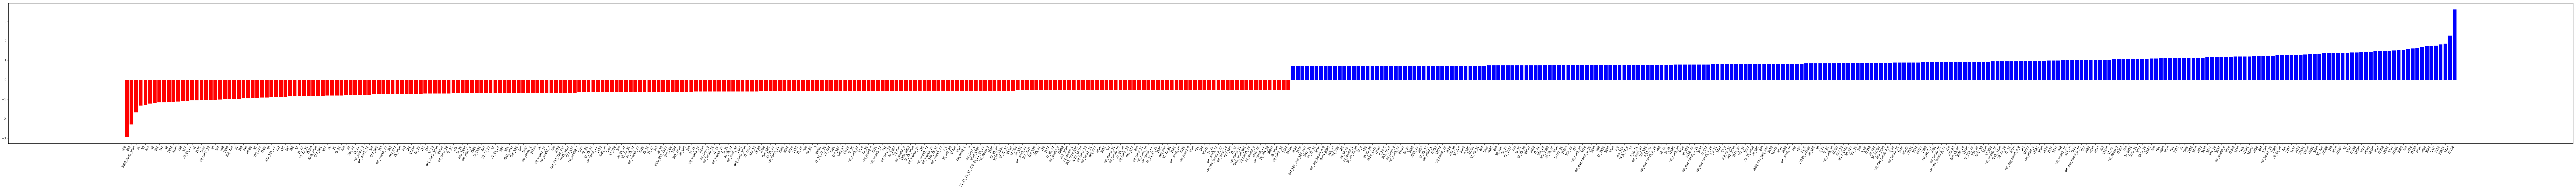

In [29]:
def plot_imp(coefs, feature_names, n_top_features=25):
    positive_coefficients = np.argsort(coefs)[-n_top_features:]
    negative_coefficients = np.argsort(coefs)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    colors = ["red" if c < 0 else "blue" for c in coefs[interesting_coefficients]]
    plt.figure(figsize=(160, 9))
    plt.bar(np.array(feature_names)[interesting_coefficients], coefs[interesting_coefficients], color=colors)
    plt.xticks(rotation=60, ha="right")
    plt.show()
plot_imp(X_train_feature_imp_coefs, X_train_feature_names, 250)

### Validation curves

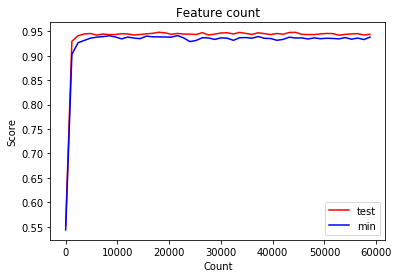

CPU times: user 31.1 s, sys: 12 s, total: 43.1 s
Wall time: 19min 13s


(0.9411585204949909, 21610)

In [30]:
%%time
def plot_vc_features(f_cnt_min, f_cnt_max):
    xx = range(f_cnt_min, f_cnt_max, int(np.ceil((f_cnt_max-f_cnt_min)/plot_cnt)))
    vc_test = []
    for f_cnt in xx:
        print('Progress: %d%% (%d/%d)\r' % ((f_cnt-f_cnt_min)*100//(f_cnt_max-f_cnt_min), f_cnt, f_cnt_max), end='')
        scores = cross_val_score(m, X_train[:,X_train_feature_imp_idxs[-f_cnt:]], y_train,
                                 cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
        vc_test += [scores]
    plt.plot(xx, np.mean(vc_test, axis=1), c='red', label='test')
    plt.plot(xx, np.min(vc_test, axis=1), c='blue', label='min')
    plt.xlabel('Count')
    plt.ylabel('Score')
    plt.title('Feature count')
    plt.legend()
    plt.show()
    scores = np.min(vc_test, axis=1)
    best_idx = np.argmax(scores)
    return scores[best_idx], xx[best_idx]
plot_vc_features(10, 60000)

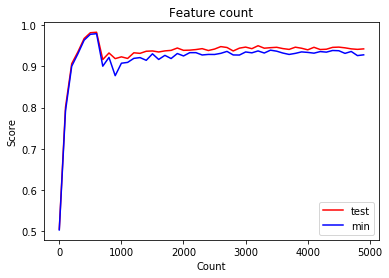

CPU times: user 14.7 s, sys: 3.02 s, total: 17.7 s
Wall time: 11min 29s


(0.9794974899774028, 601)

In [31]:
%%time
plot_vc_features(1, 5000)

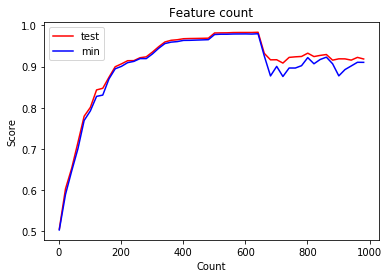

CPU times: user 5.83 s, sys: 1.16 s, total: 7 s
Wall time: 6min 4s


(0.9799197758687447, 641)

In [32]:
%%time
best_f = plot_vc_features(1, 1000)
best_f

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


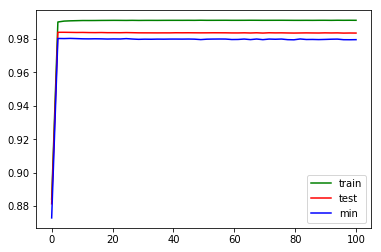

CPU times: user 4.36 s, sys: 280 ms, total: 4.64 s
Wall time: 3min 45s


(0.9839460994243535, {'logit__C': 4.081642244897958})

In [33]:
%%time
def plot_vc_C(C_min, C_max):
    C = np.linspace(C_min, C_max, plot_cnt)
    grid = GridSearchCV(m, param_grid={'logit__C': C}, return_train_score=True,
                        cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
    grid.fit(X_train[:,X_train_feature_imp_idxs[-best_f[1]:]], y_train)
    vc_train = np.vstack([grid.cv_results_[x] for x in grid.cv_results_ if 'train_score' in x and 'split' in x]).T
    vc_test = np.vstack([grid.cv_results_[x] for x in grid.cv_results_ if 'test_score' in x and 'split' in x]).T
    plt.plot(C, np.mean(vc_train, axis=1), c='green', label='train')
    plt.plot(C, np.mean(vc_test, axis=1), c='red', label='test')
    plt.plot(C, np.min(vc_test, axis=1), c='blue', label='min')
    plt.legend()
    plt.show()
    return grid.best_score_, grid.best_params_
plot_vc_C(1e-5, 100)

The baseline is **0.91252**

Strong baseline is **0.95965**

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


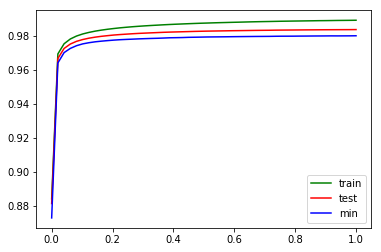

CPU times: user 4.29 s, sys: 280 ms, total: 4.57 s
Wall time: 3min 34s


(0.9835542909205474, {'logit__C': 1.0})

In [34]:
%%time
plot_vc_C(1e-5, 1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


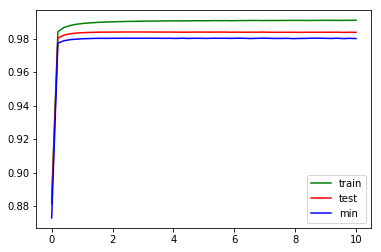

CPU times: user 4.33 s, sys: 260 ms, total: 4.59 s
Wall time: 3min 47s


(0.9840014211964148, {'logit__C': 2.4489871428571433})

In [35]:
%%time
best_C = plot_vc_C(1e-5, 10)
best_C

### Learning curves

[learning_curve] Training set sizes: [  2028   6126  10225  14323  18421  22520  26618  30716  34815  38913
  43012  47110  51208  55307  59405  63503  67602  71700  75798  79897
  83995  88093  92192  96290 100389 104487 108585 112684 116782 120880
 124979 129077 133175 137274 141372 145470 149569 153667 157766 161864
 165962 170061 174159 178257 182356 186454 190552 194651 198749 202848]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 out of 250 | elapsed:   38.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done 167 out of 250 | elapsed:  1.3min remaining:   39.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.1min finished


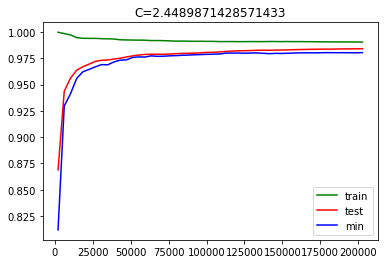

CPU times: user 1.72 s, sys: 416 ms, total: 2.14 s
Wall time: 2min 5s


In [36]:
%%time
def plot_lc(C):
    m.set_params(logit__C=C)
    train_sizes, train_scores, test_scores = learning_curve(
        m, X_train[:,X_train_feature_imp_idxs[-best_f[1]:]], y_train,
        train_sizes=np.linspace(0.01,1,plot_cnt),
        cv=5, scoring='roc_auc', n_jobs=-1, verbose=3,
        shuffle=True, random_state=17)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), c='green', label='train')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), c='red', label='test')
    plt.plot(train_sizes, np.min(test_scores, axis=1), c='blue', label='min')
    plt.legend()
    plt.title('C=' + str(C))
    plt.show()
plot_lc(best_C[1]['logit__C'])